# Classifying Yelp Reviews - Kaggle #

By Beth & Sayan

October 2016

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import KFold
from sklearn.grid_search import GridSearchCV

In [6]:
df = pd.read_csv("yelp_data_official_training.csv", sep = "|", low_memory=False)
df.head()

,ID,Category,Review Text
0,0,2,Don't waste your time. We had two different p...
1,1,2,I will start by saying we have a nice new deck...
2,2,2,When I wanted a deck for the back of my home I...
3,3,5,Our cat went out the other night and must have...
4,4,5,Greentree Animal clinic is the absolute best! ...


In [7]:
df.groupby(['Category']).agg(['count'])

,ID,Review Text
,count,count
Category,,
1,15092,15092
2,7945,7944
3,11371,11370
4,7803,7803
5,3721,3721
6,2069,2069


In [8]:
filtered_data = df["Review Text"].notnull()
df_narrative = df[filtered_data]

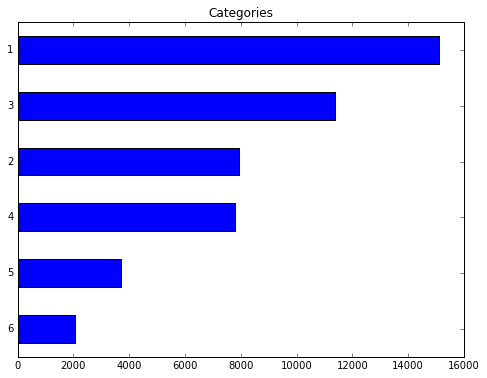

In [9]:
sorted_category_counts = df_narrative.Category.value_counts(ascending=True)
sorted_category_counts.plot(kind='barh', figsize=(8,6), title="Categories");

## Using Peter Norvig's Spelling Corrector

In [13]:
import re, string
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('big.txt').read()))

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

def edits3(word): 
    "All edits that are three edits away from `word`."
    return (e3 for e2 in edits2(word) for e2 in edits1(e2))

In [14]:
from nltk.stem import WordNetLemmatizer

def check_spelling(word):
    if word.lower() not in WORDS.keys() and word not in string.punctuation:
        return correction(word)
    else:
        return word
    
def get_word_lemmas(review):
    WNL = WordNetLemmatizer()
    review_tokens = nltk.word_tokenize(review)
    corrected_tokens = [WNL.lemmatize(word) for word in review_tokens]
    return(" ".join(corrected_tokens))

def get_word_stems(review):
    PS = nltk.stem.PorterStemmer()
    review_tokens = nltk.word_tokenize(review)
    corrected_tokens = [PS.stem(word) for word in review_tokens]
    return(" ".join(corrected_tokens))

review = '''I will start by saying we have a nice new deck. That is where the good part ends.

Why two stars if we have a nice deck now? Well, it all started in May when we had a man named Al come out and talk to us about the process. He was a true salesman, I'll tell you that. Not a straight shooter, but an excited salesman that wanted to sell... And we bought into it.

He told us they were backed up with the harsh winter and a lot of jobs, but they could probably start by June 24th. Mind you, this was the end of May we met with him. He said they would have to do a survey of our land and get a permit from Dormont before they started. We felt confident in going with them, and booked it.

Here's where things fell apart. Weeks went by with no word from them on the process. Finally I called and left messages. Al finally got in touch with me and the conversation was utterly confusing. He must have not understood me because he just kept talking in circles. So I hung up not knowing what was going on. Finally I called back and the admin told me that the survey could take a couple weeks to come back. I wish Al would have told us that.

So our June 24th date came and went. We finally got our survey. And they were quick to bill us for it, but no word on where we were in the process. I called back a couple times with no real answers from the admin. Apparently they were now waiting for the permit from Dormont.

A month later, I was frustrated and asked to speak with someone at the company. I spoke with someone who told me that Dormont usually takes a week to process the permit, but we were now going on a month. He told me he would bug the guy about it and we finally got it. 

I completely understand that waiting on the permit is not their fault, but why no communication about it? Just call me and tell me they're waiting for the permit, but they'll work towards asking Dormont what the hold up is. Seems simple.

Finally we get the permit and work is supposed to start. Tuesday comes and they have to wait for approval from Dormont on holes they're digging. So holes are dug and equipment is put in my backyard and then nothing happens for two days. Where did everyone go? Who knows, because I wasn't informed! 

I was upset and contacted the company owner, Dave, by email. I told him how frustrated I was about the lack of communication. He wrote me two sentences that  said ""there will be acres there tomorrow morning to finish and most will be done tomorrow."" Well, that didn't happen.

Then two other dudes show up two days later and did work for about three hours and left. The main guy comes back the next day and says they did it wrong. So apparently the part about how they wouldn't need access to my house changes to they're drilling bolts into my house to secure he deck. 

Finally, the second week into construction, my tiny 10x11 foot deck is done. It was upsetting that they left the deck dirty, and all the dirt and cement they moved around wasn't cleaned up. I even asked them to fill all the holes they dug up and didn't use, and they only filled up one. When you create a construction project, isn't it just good business to clean it up and make it look nice? Didn't happen here.

My main point is, contractors have a reputation for not being the most trustworthy. Why be that company? Why not be an upstanding company that consumers can trust? My main issues with them were that things were not communicated to me properly up front, nor was the ongoing process communicated to me. Then they left everything unfinished in my eyes, leaving the site dirty. I understand things happen and things get delayed, but just email or call me. It's not that hard to keep me updated, it is 2014 with a million ways to be contacted.

Even though I have a nice deck (after I clean things up myself!), I would not recommend them to anyone.'''

%timeit get_word_stems(review)
%timeit check_spelling("Hello")

100 loops, best of 3: 15.6 ms per loop
The slowest run took 21.50 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 438 ns per loop


## Seperate Training and Dev data 

- Seperate training and dev data in a 70-30 ratio. Not keeping any test data as Kaggle Data will be used for that.
- Train over entire training data set for Kaggle Submissions.
- Read Kaggle Test data 

In [15]:
random_index = np.random.permutation(df_narrative.index)
df_narrative_shuffled = df_narrative.ix[random_index, ['Category', 'Review Text']]
df_narrative_shuffled.reset_index(drop=True, inplace=True)
df_narrative_shuffled['Review Text'] = df_narrative_shuffled['Review Text'].map(get_word_stems)

In [16]:
rows, columns = df_narrative_shuffled.shape
train_size = round(rows*.70)
dev_size   = round(rows*.30)
kaggle_train_size = rows
print(df_narrative_shuffled.loc[0])

Category                                                       3
Review Text    First evalu wa easi . Appt . wa for 0800 and I...
Name: 0, dtype: object


In [17]:
df_train = df_narrative_shuffled.loc[:train_size]
df_kaggle_train = df_narrative_shuffled.loc[:kaggle_train_size]
df_dev = df_narrative_shuffled.loc[train_size:dev_size+train_size].reset_index(drop=True)
df_test = pd.read_csv("yelp_data_official_test_nocategories.csv", sep = "|", low_memory=False)
df_test['Review Text'] = df_test['Review Text'].map(get_word_stems)

In [18]:
print(TfidfVectorizer(ngram_range=(1, 1), token_pattern=r'\b\w+\b', min_df=5, max_features=18000, stop_words = 'english'))
print(SVC())
print(LinearSVC())

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=18000, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='\\b\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


In [ ]:
training_classifier = Pipeline([('tfidfvect', TfidfVectorizer(token_pattern=r'\b\w+\b', min_df=5, max_features=30000, stop_words = 'english', sublinear_tf=True) ),
                                    ('feat',SelectKBest(chi2, 5000)),
                                    ('classifier',LinearSVC(C = 1, loss='hinge'))
                                   ])

params = {
    'tfidfvect__ngram_range': ((1,1),(1,2)), 
    'classifier__C': (0.01, 0.1, 1, 10, 100), 
    'classifier__loss': ('hinge', 'squared_hinge'),
    'tfidfvect__smooth_idf': (True, False)
    }

grid_search = GridSearchCV(training_classifier, params, n_jobs=-1, verbose=1)
grid_search.fit(df_train["Review Text"],df_train.Category)


print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(data.data, data.target)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

# training_classifier = training_classifier.fit(df_train["Review Text"],df_train.Category)
    
# trial_predictions = training_classifier.predict(df_dev["Review Text"])
# accuracy = accuracy_score(df_dev.Category, trial_predictions)
# print(accuracy)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


In [5]:
kf = KFold(rows, 10, shuffle=True)
avg_accuracy = 0
for train_indices, test_indices in kf:
    df_train = df_narrative_shuffled.loc[train_indices] 
    df_dev = df_narrative_shuffled.loc[test_indices] 

    training_classifier = Pipeline([('tfidfvect', TfidfVectorizer(ngram_range=(1, 1), token_pattern=r'\b\w+\b', min_df=5, max_features=30000, stop_words = 'english', sublinear_tf=True) ),
                                    ('feat',SelectKBest(chi2, 5000)),
                                    ('classifier',LinearSVC(loss='hinge'))
                                   ])
    training_classifier = training_classifier.fit(df_train["Review Text"],df_train.Category)
    
    trial_predictions = training_classifier.predict(df_dev["Review Text"])
    accuracy = accuracy_score(df_dev.Category, trial_predictions)
    print(accuracy)
    avg_accuracy += accuracy_score(df_dev.Category, trial_predictions)
    
print(avg_accuracy/10)




NameError: name 'rows' is not defined

Log for methods:

PreProcessing | Feature Selection | Num Features | Model Selction | CV1 | CV2 | CV3 
--- | --- | --- | --- | --- | --- 
Lemmatize | sublinear=True | 18000| LSVC | 0.911748159339 | 0.911602347711 |
None | sublinear=True | 18000| LSVC | 0.91158152306 | 0.910560594221 |
Lemmatize | sublinear=False| 18000| LSVC | 0.910873207092 | 0.911102256547 |
Lemmatize | sublinear=True | 18000| LSVC loss='hinge' | 0.913185650656| 0.914206575155 |
None | sublinear=True | 18000| LSVC loss='hinge' | 0.914060759186| 0.913352256547 | 0.9136649519
Stemming | sublinear=True | 5000 Chi2 from 30K | LSVC loss='hinge' | 0.912727247864| 0.913435646315 |



In [19]:
df_dev.to_csv("dev_data.csv")

prediction_df = pd.DataFrame(data=trial_predictions, columns=["Category"])
prediction_df["Id"] = prediction_df.index
cols = ["Id","Category"]

prediction_df[cols].to_csv("trial_results.csv", index=False)

In [20]:
class_labels = np.sort(df_dev.Category.unique())
class_labels = [str(x) for x in class_labels]

In [51]:
print(classification_report(df_dev.Category, trial_predictions, target_names=class_labels))
print("\n\n***Confusion Matrix***\n\n")
print(confusion_matrix(df_dev.Category, trial_predictions))

             precision    recall  f1-score   support

          1       0.94      0.94      0.94      4611
          2       0.87      0.89      0.88      2377
          3       0.92      0.94      0.93      3378
          4       0.85      0.85      0.85      2303
          5       0.93      0.90      0.92      1107
          6       0.91      0.79      0.85       624

avg / total       0.91      0.91      0.91     14400



***Confusion Matrix***


[[4319   61  121   99    3    8]
 [  56 2106   36  167    4    8]
 [  96   39 3181   53    7    2]
 [  77  199   61 1959    2    5]
 [   5    6   64    7 1001   24]
 [  28   13    8   23   58  494]]


In [52]:
def plot_confusion_matrix(cm, title, target_names, cmap=plt.cm.coolwarm):
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

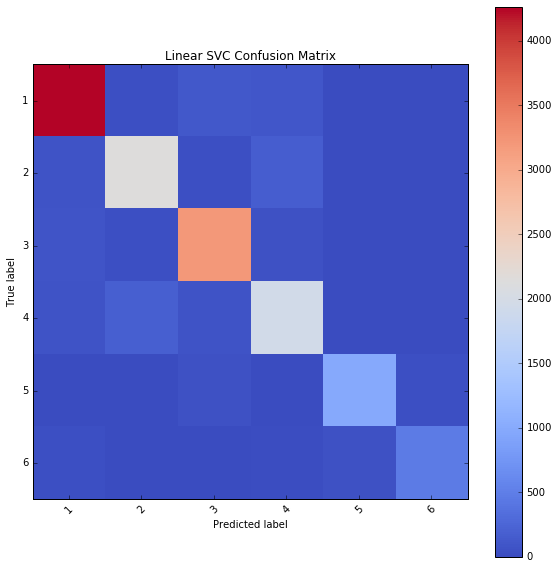

In [34]:
trial_cm = confusion_matrix(df_dev.Category, trial_predictions)
plot_confusion_matrix(trial_cm, "Linear SVC Confusion Matrix", class_labels)

In [ ]:
kaggle_classifier = Pipeline([('tfidfvect', TfidfVectorizer(ngram_range=(1, 1), token_pattern=r'\b\w+\b', min_df=5, max_features=30000, stop_words = 'english', sublinear_tf=True) ),
                                ('feat',SelectKBest(chi2, 8000)),
                                ('classifier',SVC(gamma=0.8, probability=True))
                                ])
kaggle_classifier = kaggle_classifier.fit(df_kaggle_train["Review Text"],df_kaggle_train.Category)
    
kaggle_predictions = kaggle_classifier.predict(df_test["Review Text"])

In [43]:
# accuracy_score(df_dev.Category, nb_kaggle_predictions)

prediction_df = pd.DataFrame(data=kaggle_predictions, columns=["Category"])
prediction_df["Id"] = prediction_df.index
cols = ["Id","Category"]

prediction_df[cols].to_csv("kaggle_svc_rbf_8000_hinge_submission.csv", index=False)